<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-fidelity reduced-order modeling on Groundwater's flow - Darcy equation**

#### We aim to create a reduced-order surrogate model that enables the efficient recovery of high-fidelities solutions over time and parameter variations, starting from their low-fidelity counterparts.

#### We consider a data-driven strategy that combines dimensionality reduction via Proper Orthogonal Decompostion (POD) with multi-fidelity long-short term memory neural (LSTM) network surrogates.


#### (1) **Generation of multi-fidelity dataset**
#### (2) **Dimensionality reduction via POD**
#### (3) **Computing reduced-coordinates via projection**
#### (4) **Training LSTM neural network surrogate model**



#### Import libraries

In [2]:
import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
import pandas as pd 
from tensorflow.keras.optimizers import Adam,Nadam,Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from sklearn.utils import extmath

#######################     CONFIGURATIONS     ##########################
seed = 29
train = True
save = True

#### Problem setup
Consider steady groundwater flow in a confined, inhomogeneous aquifer which occupies the domain $\Omega$ with boundary $\Gamma$. 
Assuming that water is incompressible, the governing equations for groundwater flow can be written as the scalar elliptic partial differential equation:
$$
-\nabla \cdot(-T(\mathbf{x}) \nabla h(\mathbf{x}))=g(\mathbf{x}) \text { for all } \quad \mathbf{x} \in \Omega
$$
subject to boundary conditions on $\Gamma=\Gamma_N \cup \Gamma_D$ defined by the constraint equations
$$
h(\mathbf{x})=h_D(\mathbf{x}) \quad \text { on } \Gamma_D \quad \text { and } \quad(-T(\mathbf{x}) \nabla h(\mathbf{x})) \cdot \boldsymbol{n}=q_N(\mathbf{x}) \quad \text { on } \Gamma_N .
$$

Here $T(\mathbf{x})$ is the heterogeneous, depth-integrated transmissivity, $h(\mathbf{x})$ is hydraulic head, $h_D(\mathbf{x})$ is fixed hydraulic head at boundaries with Dirichlet constraints, $g(\mathbf{x})$ is fluid sources and sinks, $q(\mathbf{x})$ is Darcy velocity, $q_N(\mathbf{x})$ is Darcy velocity across boundaries with Neumann constraints and $\Gamma_D \subset \partial \Omega$ and $\Gamma_N \subset \partial \Omega$ define the boundaries comprising of Dirichlet and Neumann conditions, respectively. Following standard FEM practice (see e.g. [19]), eq. (1) is converted into weak form by multiplying by an appropriate test function $w \in H^1(\Omega)$ and integrating by parts, so that
$$
\int_{\Omega} \nabla w \cdot(T(\mathbf{x}) \nabla h) d \mathbf{x}+\int_{\Gamma_N} w q_N(\mathbf{x}) d s=\int_{\Omega} w g(\mathbf{x}) d \mathbf{x}, \quad \forall w \in H^1(\Omega),
$$
where $H^1(\Omega)$ is the Hilbert space of weakly differentiable functions on $\Omega$. To approximate the hydraulic head solution $h(\boldsymbol{x})$, a finite element space $V_\tau \subset H^1(\Omega)$ on a finite element mesh $\mathcal{Q}_\tau(\Omega)$. This is defined by a basis of piecewise linear Lagrange polynomials $\left\{\phi_i(\mathbf{x})\right\}_{i=1}^M$, associated with each of the $M$ finite element nodes. As a result (3) can be rewritten as a system of sparse linear equations
$$
\begin{aligned}
\mathbf{A h}=\mathbf{b} \quad \text { where } \quad A_{i j} & =\int_{\Omega} \nabla \phi_i \cdot T(\mathbf{x}) \nabla \phi_j(\mathbf{x}) d \mathbf{x} \text { and } \\
b_i & =\int_{\Omega} \phi_i(\mathbf{x}) g(\mathbf{x}) d \mathbf{x}-\int_{\Gamma_N} \phi_i(\mathbf{x}) q_N(\mathbf{x}) d s
\end{aligned}
$$
where $\mathbf{A} \in \mathbb{R}^{M \times M}$ and $\mathbf{b} \in \mathbb{R}^M$ are the global stiffness matrix and load vector, respectively. The vector $\mathbf{h}:=\left[h_1, h_2, \ldots, h_M\right] \in \mathbb{R}^M$ is the solution vector of hydraulic head at each node within the finite element mesh so that $h(\mathbf{x})=\sum_{i=1}^M h_i \phi_i(\mathbf{x})$. In our numerical experiments, these equations are solved using the open source general-purpose FEM framework FEniCS. While there are well-established groundwater simulation software packages available, such as MODFLOW  and FEFLOW [19], FEniCS was chosen because of its flexibility and ease of integration with other software and analysis codes.


# DATASET N = 32000
The dataset has been developed using fenics library, it is composed of 64000 samples divided in 90% training and 10% testing.\
The input (or X) are the 64 first component of the Karhunen-Loève (KL) decompositions. \
These eigenmodes allow to paratetrize a random field in the most accurate way.

In [12]:
X_test = np.loadtxt("./data/X_test_32000.csv" , delimiter = ",")
y_test = np.loadtxt("./data/y_test_32000.csv" , delimiter = ",")

X_train =np.loadtxt("./data/X_train_32000.csv" , delimiter = ",")
y_train =np.loadtxt("./data/y_train_32000.csv" , delimiter = ",")

n_eig = 64

The output: 25 sensors are used to record the hydraulic pressure in the domain $\Omega$ \
The sensors are distributed on a grid with positions [0.1, 0.3, 0.5, 0.7, 0.9]



#### (4ii) Training Fully connected neural network surrogate model

Before introducing the POD in the creation of the model, let us explore how a direct (and therefore simpler) map would perform in this environment \

Let us first try to create a map $T(x) \rightarrow u(x)$ 

Create a NN that takes in inuput the 64 eigenvalues of the transittivity field and returns the hydraulic pressure in the 25 points where the sensors are located 


In [13]:
Training = False


# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return max(lr * 0.99, 1e-5)

# Initialize the neural network model
model = Sequential()

# Add layers to the model
model.add(Dense(128, input_shape=(n_eig,), activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(25, activation='linear'))


if Training:
    # Compile the model
    initial_learning_rate = 0.005
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define the learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the model
    history = model.fit(X_train, y_train, 
                    epochs=1000, 
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lr_scheduler])
    
    model.save('./models/model_LF_32000.keras')

model = load_model('./models/model_LF_32000.keras')



In [14]:
# Evaluate the model on the test set
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

if Training:
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.legend()
    plt.show()



100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - loss: 4.7323e-05 
Test accuracy: 4.804746640729718e-05
Test rmse: 0.006931627976694737


Se how it is able to prodict 

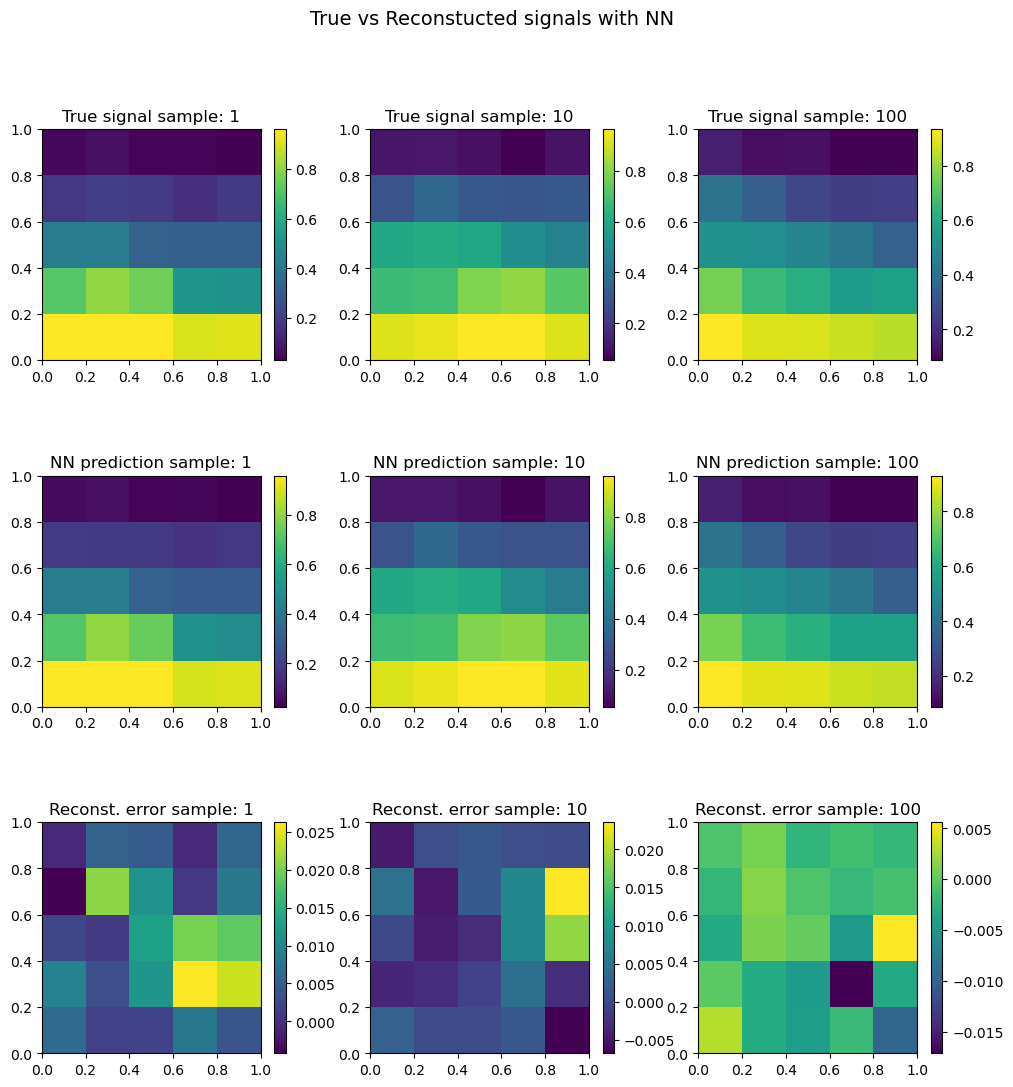

In [15]:
# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# Grid to plot the basis 
X,Y = np.meshgrid(x_data, y_data)

samples = [ 1, 10, 100]
#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
title = 'True vs Reconstucted signals with NN'
fig.suptitle(title, fontsize=14)

for mode in range(3):
    ax = fig.add_subplot(331 + mode)
    pcm = plt.pcolormesh(X, Y, y_test[mode, :].reshape((5, 5)))
    ax.title.set_text('True signal sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 3)
    reconstructed_sample = np.array(model(X_test[mode, :].reshape((1, n_eig)))).reshape((5, 5))
    err = y_test[mode, :].reshape(5, 5) - reconstructed_sample
    pcm = plt.pcolormesh(X, Y, reconstructed_sample.reshape((5, 5)))
    ax.title.set_text('NN prediction sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 6)
    pcm = plt.pcolormesh(X, Y, err)
    ax.title.set_text('Reconst. error sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)


# Dataset N = 64000

In [15]:
X_test = np.loadtxt("./data/X_test_64000.csv" , delimiter = ",")
y_test = np.loadtxt("./data/y_test_64000.csv" , delimiter = ",")

X_train =np.loadtxt("./data/X_train_32000.csv" , delimiter = ",")
y_train =np.loadtxt("./data/y_train_32000.csv" , delimiter = ",")

n_eig = 64

In [17]:
Training = False


# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return max(lr * 0.99, 1e-5)

# Initialize the neural network model
model = Sequential()

# Add layers to the model
model.add(Dense(128, input_shape=(n_eig,), activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(25, activation='linear'))


if Training:
    # Compile the model
    initial_learning_rate = 0.005
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define the learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the model
    history = model.fit(X_train, y_train, 
                    epochs=1000, 
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lr_scheduler])
    
    model.save('./models/model_LF_64000.keras')

model = load_model('./models/model_LF_64000.keras')



In [18]:
# Evaluate the model on the test set
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

if Training:
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.legend()
    plt.show()



200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 3.0932e-05
Test accuracy: 3.099271634710021e-05
Test rmse: 0.005567110233065285


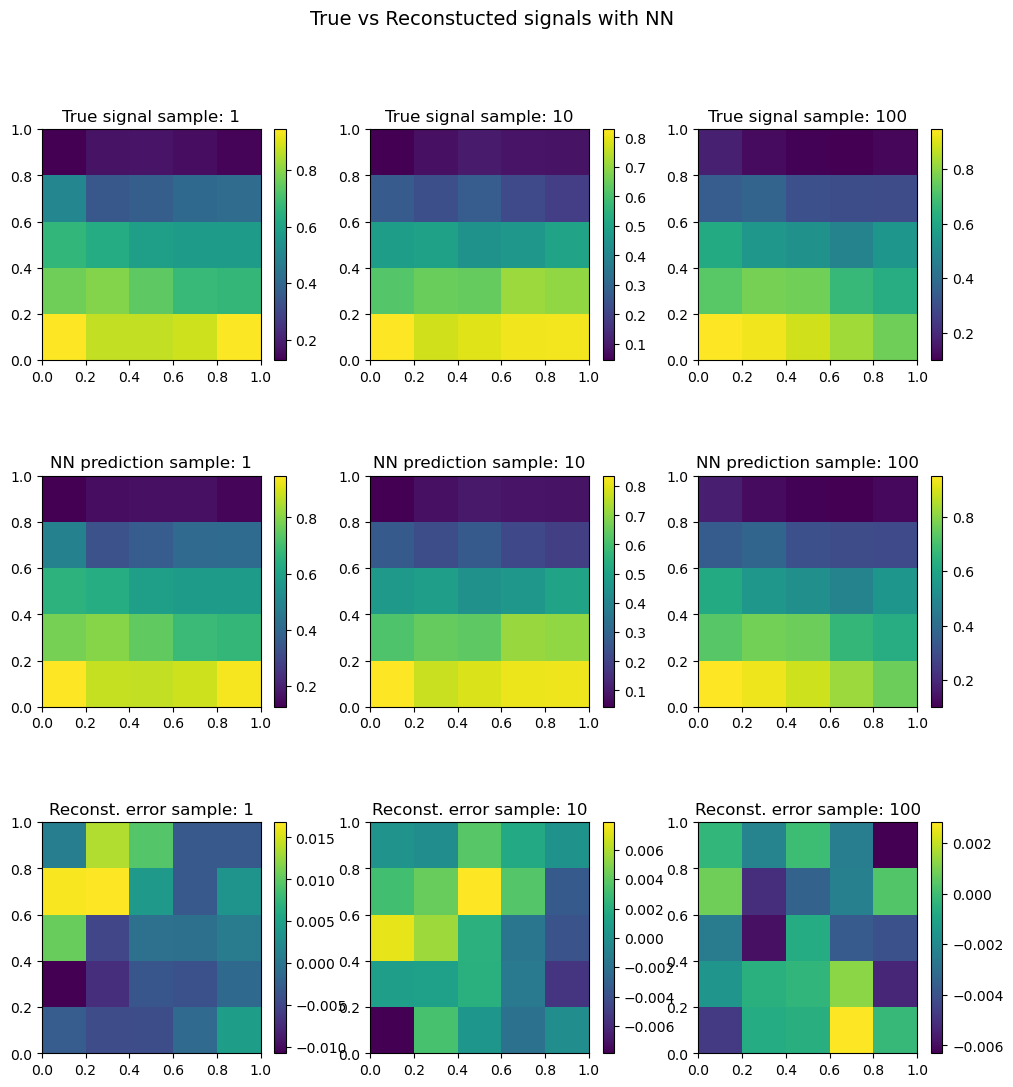

In [10]:
# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# Grid to plot the basis 
X,Y = np.meshgrid(x_data, y_data)

samples = [ 1, 10, 100]
#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
title = 'True vs Reconstucted signals with NN'
fig.suptitle(title, fontsize=14)

for mode in range(3):
    ax = fig.add_subplot(331 + mode)
    pcm = plt.pcolormesh(X, Y, y_test[mode, :].reshape((5, 5)))
    ax.title.set_text('True signal sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 3)
    reconstructed_sample = np.array(model(X_test[mode, :].reshape((1, n_eig)))).reshape((5, 5))
    err = y_test[mode, :].reshape(5, 5) - reconstructed_sample
    pcm = plt.pcolormesh(X, Y, reconstructed_sample.reshape((5, 5)))
    ax.title.set_text('NN prediction sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 6)
    pcm = plt.pcolormesh(X, Y, err)
    ax.title.set_text('Reconst. error sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)


# EVALUATION OF DIFFERENT MODELS

In [13]:
X_test = np.loadtxt("./data/X_test_64000.csv" , delimiter = ",")
y_test = np.loadtxt("./data/y_test_64000.csv" , delimiter = ",")

X_train =np.loadtxt("./data/X_train_64000.csv" , delimiter = ",")
y_train =np.loadtxt("./data/y_train_64000.csv" , delimiter = ",")

n_eig = X_test.shape[1]
n_eig


64

### MODEL LF 1

In [49]:
model = Sequential()

# Add layers to the model
model.add(Dense(128, input_shape=(n_eig,), activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(25, activation='linear'))

/Users/lucacaroselli/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training sample 64000

In [50]:
model = load_model('./models/model_LF_64000_1.keras')

In [51]:
# Evaluate the model on the test set
training_loss = model.evaluate(x=X_train, y=y_train)
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

1800/1800 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - loss: 2.6562e-05
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - loss: 3.0932e-05
Training accuracy: 2.655429852893576e-05
Test accuracy: 3.099271634710021e-05
Test rmse: 0.005567110233065285


Training sample 32000

In [52]:
model = load_model('./models/model_LF_32000_2.keras')

In [53]:
# Evaluate the model on the test set
training_loss = model.evaluate(x=X_train, y=y_train)
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

1800/1800 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - loss: 1.0941e-04
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 1.0909e-04
Training accuracy: 0.00010953481978503987
Test accuracy: 0.00010859387111850083
Test rmse: 0.010420838311695504


### MODEL LF 2 

In [54]:
model = Sequential()

# Add layers to the model
model.add(Dense(128, input_shape=(n_eig,), activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(25, activation='exponential'))

Training sample = 64000

In [55]:
model = load_model('./models/model_LF_64000_2.keras')

In [56]:
# Evaluate the model on the test set
training_loss = model.evaluate(x=X_train, y=y_train)
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

1800/1800 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - loss: 5.9662e-05
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 6.5892e-05
Training accuracy: 5.971408972982317e-05
Test accuracy: 6.582085188711062e-05
Test rmse: 0.008113005108288211


Training sample = 32000

In [57]:
model = load_model('./models/model_LF_32000_1.keras')

In [58]:
# Evaluate the model on the test set
training_loss = model.evaluate(x=X_train, y=y_train)
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

1800/1800 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - loss: 4.6058e-05
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 4.5899e-05
Training accuracy: 4.61285344499629e-05
Test accuracy: 4.6089597162790596e-05
Test rmse: 0.006788931960388953


### MODEL LF 3

In [59]:
model = Sequential()

# Add layers to the model
model.add(Dense(128, input_shape=(n_eig,), activation='gelu'))
model.add(Dense(128, activation='gelu'))
model.add(Dense(64, activation='gelu'))
model.add(Dense(25, activation='exponential'))

Training sample = 64000

In [60]:
model = load_model('./models/model_LF_64000_3.keras')

In [61]:
# Evaluate the model on the test set
training_loss = model.evaluate(x=X_train, y=y_train)
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

1800/1800 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - loss: 2.3522e-05
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 2.7815e-05
Training accuracy: 2.3532213162980042e-05
Test accuracy: 2.7629030228126794e-05
Test rmse: 0.0052563323932307395


Training sample = 32000

In [62]:
model = load_model('./models/model_LF_32000_3.keras')

In [63]:
# Evaluate the model on the test set
training_loss = model.evaluate(x=X_train, y=y_train)
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

1800/1800 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - loss: 3.6216e-05
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 3.5890e-05
Training accuracy: 3.6094686947762966e-05
Test accuracy: 3.539337922120467e-05
Test rmse: 0.0059492334986285976


# BONUS 

This model would be too big to be used as a low fidelity model yet was calculataed to set a benchmark for the performane of larger Networks. 

To be more specific this model will help highlight the contribution that the knowledge on the POD coefficient give to the same Neural Network (model_POD_1)

In [64]:
model = Sequential()

# Add layers to the model
model.add(Dense(256, input_shape=(n_eig,), activation='gelu'))
model.add(Dense(256, activation='gelu'))
model.add(Dense(256, activation='gelu'))
model.add(Dense(25, activation='exponential'))

model = load_model('./models/model_LF_64000_4.keras')

In [65]:
# Evaluate the model on the test set
training_loss = model.evaluate(x=X_train, y=y_train)
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Training accuracy: {training_loss}")
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - loss: 1.3567e-05
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 1.3916e-05
Training accuracy: 1.3542909982788842e-05
Test accuracy: 1.3684657460544258e-05
Test rmse: 0.0036992779647580225
